## Start from importing dataset loading module and numpy for some processing

In [1]:
from mnist import MNIST
import numpy as np

In [2]:
# initialize a dataset loader and use gzip files
mnist_data = MNIST(path='./samples/', gz=True)

In [3]:
train_data = mnist_data.load_training()

In [4]:
len(train_data)

2

### The training set contains 60,000 examples

In [5]:
len(train_data[0])

60000

In [6]:
len(train_data[1])

60000

### train_data[0] is the input arrays (images)

In [7]:
len(train_data[0][0])

784

In [8]:
len(train_data[1][0]) # Since train_data[1] is a list of integers, calling len() on integers causes an error

TypeError: object of type 'int' has no len()

In [9]:
print(type(train_data[0]), type(train_data[1]))

<class 'list'> <class 'array.array'>


### load_training() returns a tuple with two lists: [1] lists of values for data points (60000 lists, each with 784 entries), [2] a list of labels as integers (60000 integers)

In [10]:
X_train = np.array(train_data[0])
y_train = np.array(train_data[1]).reshape((-1, 1))

In [11]:
X_train.shape

(60000, 784)

In [12]:
y_train.shape

(60000, 1)

In [13]:
X_train.max()

255

In [14]:
X_train.min()

0

In [15]:
y_train.max()

9

In [16]:
y_train.min()

0

## Import matplotlib for visualization

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Let's pick 5 random images from the training set!

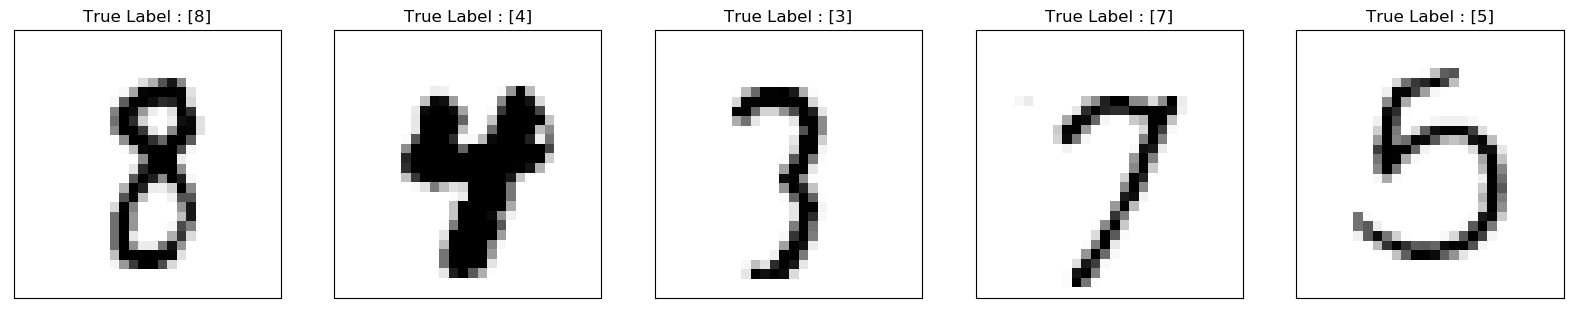

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20), dpi=100)
for n, ax in zip(np.random.permutation(len(X_train))[:5], axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("True Label : " + str(y_train[n]))
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

## Now that we checked that the dataset is good, let's load test dataset as well!

In [19]:
X_test, y_test = mnist_data.load_testing()
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

## Import torch for neural networks

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Use CUDA device if available. Use CPU otherwise

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Input Normalization
* currently this doesn't seem to provide any significant improvement in training, so it is defined but not used for now

In [22]:
def normalize(input_tensor, dim=None):
    if dim is None:
        mean = input_tensor.data.mean()
        std = input_tensor.data.std()
    else:
        mean = input_tensor.data.mean(dim=dim)
        std = input_tensor.data.std(dim=dim)

    input_tensor.data = input_tensor.data - mean # mean of 0
    input_tensor.data = input_tensor.data / std.max(torch.tensor(1e-12, dtype=std.dtype, device=std.device)) # standard deviation of 1, prevent division by zero
    
def convert_and_normalize_input(X, dtype=None, device=None, dim=None):
    X_minmaxed = torch.tensor(X / 255, dtype=dtype, device=device)

    normalize(X_minmaxed, dim=dim)
    X_normalized = X_minmaxed

    return X_normalized

## Do minmax scaling and transform into torch tensors

In [23]:
# X_train = convert_and_normalize_input(X_train, dtype=torch.float64, device=device)
# X_test = convert_and_normalize_input(X_test, dtype=torch.float64, device=device)
X_train = torch.tensor(X_train / 255, dtype=torch.float64, device=device)
X_test = torch.tensor(X_test / 255, dtype=torch.float64, device=device)

In [24]:
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [25]:
X_train.shape

torch.Size([60000, 784])

In [26]:
X_test.shape

torch.Size([10000, 784])

### For classification, we also need to turn the labels to one-hot vectors (vectors each having value 1 for corresponding class and 0 for everything else)

In [27]:
def labels_to_onehot(Y, device=None):
    return torch.tensor(Y, dtype=torch.uint8, device=device).eq(torch.arange(0, 10, dtype=torch.uint8, device=device))

In [28]:
Y_train = labels_to_onehot(y_train, device=device)
Y_train.data = Y_train.data.type(torch.float64)
Y_test = labels_to_onehot(y_test, device=device)
Y_test.data = Y_test.data.type(torch.float64)

## For hyperparameter tuning in the future, the training set is randomly devided into 50,000 training examples and 10,000 validation examples

In [29]:
# Take out some examples from the training set as the validation set (50000 for training, 10000 for validation)
randidx = torch.randperm(len(X_train))
X_val = X_train[randidx[:10000]]
X_train = X_train[randidx[10000:]]
Y_val = Y_train[randidx[:10000]]
Y_train = Y_train[randidx[10000:]]

In [30]:
print(len(X_train))
print(len(X_val))
print(len(Y_train))
print(len(Y_val))

50000
10000
50000
10000


## Initialize weights and biases
Two layers - layer1 : (input to hidden) -> layer2 : (hidden to output)

In [31]:
epsilon = 0.01

w1 = torch.tensor(torch.rand(100, X_train.shape[1], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b1 = torch.tensor(torch.rand(100, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
w2 = torch.tensor(torch.rand(10, w1.shape[0], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b2 = torch.tensor(torch.rand(10, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)

In [32]:
w1

tensor([[-0.0010,  0.0075,  0.0079,  ...,  0.0072, -0.0032,  0.0008],
        [-0.0050, -0.0070, -0.0094,  ...,  0.0052,  0.0082, -0.0088],
        [-0.0097, -0.0068,  0.0011,  ...,  0.0061,  0.0065,  0.0017],
        ...,
        [ 0.0084, -0.0020, -0.0009,  ..., -0.0093, -0.0071, -0.0083],
        [ 0.0057,  0.0076, -0.0029,  ..., -0.0060, -0.0070, -0.0082],
        [ 0.0009,  0.0020, -0.0073,  ..., -0.0097, -0.0052,  0.0010]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

## Useful and necessary functions
- re-initializing parameters (4 different methods are available : uniform, standard normal (std can be adjusted), He, and Xavier)
- mini-batch sampling (Generater function that yields mini-batch samples every iteration)
- feedforward
- prediction (Turns raw probability values into prediction labels; integer values)
- binary cross entropy loss
- L2 regularization loss
- loss function (cross entropy + L2 regularization)
- accuracy evaluation

In [33]:
def reset(tensors, method='uniform', e=0.01):
    """
    re-initialize parameters using the given method
    
    tensors : 'list' of tensors
    method : {'uniform'|'std'|'he'|'xavier'}, default:'uniform'
    e : maximum absolute value for 'uniform' | standard deviation for 'std' | ignored otherwise
    """
    method = method.lower()
    
    if method not in ('uniform', 'std', 'he', 'xavier'):
        raise ValueError("method must be one of these options : {'uniform'|'std'|'he'|'xavier'}")
    
    if method == 'uniform':
        for tensor in tensors:
            tensor.data = torch.tensor(torch.rand(tensor.size(), dtype=tensor.dtype, device=tensor.device) * 2 * e - e)
    elif method == 'std':
        for tensor in tensors:
            tensor.data = torch.tensor(torch.randn(tensor.size(), dtype=tensor.dtype, device=tensor.device) * e)
    elif method == 'he':
        for tensor in tensors:
            tensor.data = torch.tensor(torch.randn(tensor.size(), dtype=tensor.dtype, device=tensor.device) * torch.sqrt(torch.tensor(2 / tensor.size()[1], dtype=tensor.dtype, device=tensor.device)))
    else:
        for tensor in tensors:
            tensor.data = torch.tensor(torch.randn(tensor.size(), dtype=tensor.dtype, device=tensor.device) * torch.sqrt(torch.tensor(2 / sum(tensor.size()), dtype=tensor.dtype, device=tensor.device)))


def mini_batch(X, Y=None, batch_size=100, shuffle=True):
    assert Y is None or len(X) == len(Y), "length of the first dimensions in both matrices must match"
    assert isinstance(batch_size, int), "the batch size must be an integer"
    
    if batch_size > len(X) or batch_size <= 0:
        batch_size = len(X)
    
    n_batches = len(X) // batch_size
    
    if shuffle is True:
        rand_idx = torch.randperm(len(X))
        if Y is None:
            for batch_idx in range(n_batches):
                yield X[rand_idx[batch_size * batch_idx:batch_size * (batch_idx + 1)]]
        else:
            for batch_idx in range(n_batches):
                yield (X[rand_idx[batch_size * batch_idx:batch_size * (batch_idx + 1)]],
                       Y[rand_idx[batch_size * batch_idx:batch_size * (batch_idx + 1)]])
                
    else:
        if Y is None:
            for batch_idx in range(n_batches):
                yield X[batch_size * batch_idx:batch_size * (batch_idx + 1)]
        else:
            for batch_idx in range(n_batches):
                yield (X[batch_size * batch_idx:batch_size * (batch_idx + 1)],
                       Y[batch_size * batch_idx:batch_size * (batch_idx + 1)])
    

def feedforward(input_data, weight_matrices, biase_matrices=None):
    assert biase_matrices is None or len(weight_matrices) == len(biase_matrices)
    
    output = input_data.clone()
    
    for n, weights in enumerate(weight_matrices):
        output = output.mm(weights.t())
        if biase_matrices is not None:
            output = output + biase_matrices[n].t()
        output = torch.sigmoid(output)
    
    return output


def predict(probs, one_hot=False):
    preds = torch.tensor(probs.argmax(dim=1).reshape((-1, 1)), dtype=torch.uint8, device=probs.device)

    if one_hot is True:
        preds.data = preds.eq(torch.arange(0, 10, dtype=torch.uint8, device=probs.device))

    return preds


def binary_class_cross_entropy_loss(pred, true, per_example=False):
    assert len(pred) == len(true)
    
    loss = torch.sum(-true * torch.log(pred) - (1 - true) * torch.log(1 - pred), dim=1, dtype=pred.dtype)
    if per_example is False:
        loss = loss.sum() / len(true)
        if loss.item() != loss.item(): # if the result is nan (probably due to 0 value inside log functions)
            loss = torch.sum(-true * torch.log(pred + 1e-12) - (1 - true) * torch.log(1 - pred + 1e-12), dtype=pred.dtype)
    
    return loss


def regularization_loss(weight_matrices, regular_coef, n_examples):
    loss = (regular_coef / (2 * n_examples)) * sum([weights.pow(2).sum() for weights in weight_matrices])
    return loss


def loss_function(prob, true, weight_matrices, regular_coef, n_examples):
    return binary_class_cross_entropy_loss(prob, true) + regularization_loss(weight_matrices, regular_coef, n_examples)


def accuracy_score(pred, true):
    assert len(pred) == len(true)

    pred = pred.cuda().argmax(dim=1)
    true = true.cuda().argmax(dim=1)

    accuracy = pred.eq(true).sum(dtype=pred.dtype).item() / float(len(true))

    return accuracy

In [34]:
# Bundle the weights and biases into two separate lists so that I can use them for my functions
weights = [w1, w2]
biases = [b1, b2]

### Here, re-initialize the parameters using He et al initialization

In [35]:
reset(weights + biases, method='he')

## Setting up logs
These will help tracking the progress

In [36]:
# Set up logs
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

## Finding optimal learning rate
From [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

In [37]:
# Finding the best learning rate
def lr_find(X, Y, weight_matrices, bias_matrices, batch_size=100, start_lr=1e-4, end_lr=1.0, n_steps=100, reg_coef=0, reset_method='uniform', e=0.01):
    assert start_lr <= end_lr, "'end_lr' must be greater than or equal to 'start_lr'"
    assert isinstance(n_steps, int) and n_steps >= 0, "'n_steps' must be an integer value greater than or equal to 0"
    
    # Use the clones so that we won't end up messing up with our original weights...
    weight_matrices = [weight.clone() for weight in weight_matrices]
    bias_matrices = [bias.clone() for bias in bias_matrices]
    params = weight_matrices + bias_matrices
    reset(params, method=reset_method, e=e)
    
    # Since cloned tensors are "edges", they do not retain gradients by default.
    # We have to manually set it
    for param in params:
        param.retain_grad()

    learning_rate = start_lr
    lr_history = []
    acc_history = []
    
    lr_diff = end_lr - start_lr
    
    lr_step_change = lr_diff / n_steps
    
    report_every_n_steps = n_steps // 10

    step_count = 0
    
    while step_count < n_steps:
        for X_batch, Y_batch in mini_batch(X, Y, batch_size=batch_size):
            output = feedforward(X, weight_matrices, bias_matrices)
            loss = loss_function(output, Y, weight_matrices, reg_coef, len(X))
            loss.backward()

            for param in params:
                param.data -= learning_rate * param.grad.data
                param.grad.data.zero_()

            lr_history.append(learning_rate)
            acc_history.append(accuracy_score(predict(output, one_hot=True), Y))

            learning_rate += lr_step_change
            
            step_count += 1

            if step_count % report_every_n_steps == 0:
                print(f"{step_count} step(s) of {n_steps} ...")
            
            if step_count >= n_steps:
                break
    
    return (lr_history, acc_history)


def lr_plot(lr_list, acc_list, log_scale=False):
    if log_scale:
        plt.xscale('log')
    plt.locator_params(axis='y', nbins=10)
    plt.xlabel('learning rate' + ('', '(in log scale)')[bool(log_scale)])
    plt.ylabel('accuracy')
    plt.grid()
    plt.plot(lr_list, acc_list)

In [38]:
logs = lr_find(X_train, Y_train, weights, biases, batch_size=-1, start_lr=1e-1, end_lr=3.0, n_steps=100, reg_coef=1, reset_method='he')
print(len(logs[0]))

10 step(s) of 100 ...
20 step(s) of 100 ...
30 step(s) of 100 ...
40 step(s) of 100 ...
50 step(s) of 100 ...
60 step(s) of 100 ...
70 step(s) of 100 ...
80 step(s) of 100 ...
90 step(s) of 100 ...
100 step(s) of 100 ...
100


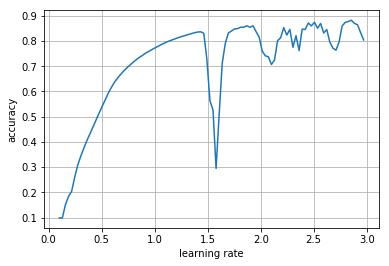

In [39]:
# The entire plot
lr_plot(logs[0], logs[1])

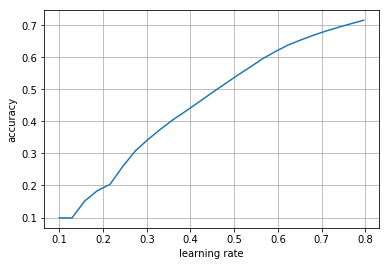

In [40]:
# First quarter
lr_plot(logs[0][:len(logs[0])//4], logs[1][:len(logs[0])//4])

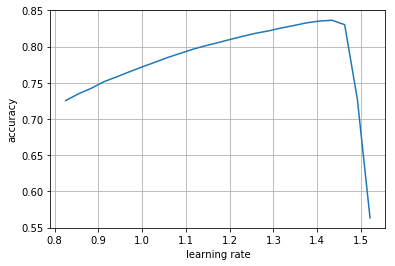

In [41]:
# Second quarter
lr_plot(logs[0][len(logs[0])//4:len(logs[0])//2], logs[1][len(logs[0])//4:len(logs[0])//2])

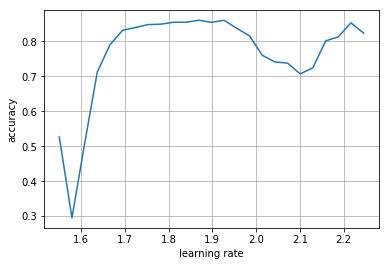

In [42]:
# Third quarter
lr_plot(logs[0][len(logs[0])//2:(len(logs[0])*3)//4], logs[1][len(logs[0])//2:(len(logs[0])*3)//4])

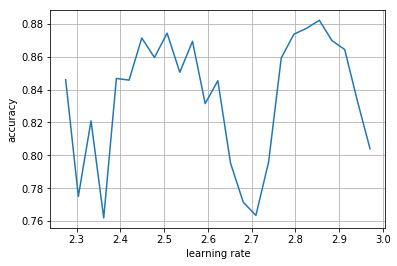

In [43]:
# Forth quarter
lr_plot(logs[0][(len(logs[0])*3)//4:], logs[1][(len(logs[0])*3)//4:])

## Let's now set hyperparameters and start training!

In [44]:
# Hyperparameters
epoch = 100
lambda_term = 1
learning_rate = 1.0
batch_size = -1 # the entire training set

In [45]:
tol_loss = 1e-3
tol_step = 1e-8

reset_progress = True

initialization = 'he'

if reset_progress is True:
    reset(weights, method=initialization)
    reset(biases, method=initialization)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

exit_reason = ""

backups = [{'parameters':[param.clone() for param in (weights + biases)],
            'index':len(train_loss_history),
            'train_loss':999 if train_loss_history == [] else train_loss_history[-1]}]

backup_during_training = True
n_checkpoint = 10 # backup the parameters and iteration number n_checkpoint times during a full set of iterations

checkpoint_interval = epoch // n_checkpoint
for iteration in range(epoch):
    batch_losses = []
    batch_accs = []
    for X_batch, Y_batch in mini_batch(X_train, Y_train, batch_size=batch_size):
        output = feedforward(X_batch, weights, biases)
        loss = loss_function(output, Y_batch, weights, lambda_term, len(X_batch))

        loss.backward()

        for param in (weights + biases):
            param.data -= learning_rate * param.grad.data
            param.grad.data.zero_()

        train_pred = predict(output, one_hot=True)
        
        batch_losses.append(loss.item())
        batch_accs.append(accuracy_score(train_pred, Y_batch))

    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_acc = sum(batch_accs) / len(batch_accs)
    train_loss_history.append(avg_loss)
    train_acc_history.append(avg_acc)
    
    val_prob = feedforward(X_val, weights, biases)
    val_pred = predict(val_prob, one_hot=True)

    val_loss_history.append(binary_class_cross_entropy_loss(val_prob, Y_val).item())
    val_acc_history.append(accuracy_score(val_pred, Y_val))
    
    if (iteration + 1) % 10 == 0 or iteration == 0:
        print(f"\nIteration {iteration + 1}")
        print(f"[Training Loss = {train_loss_history[-1]:.6f}\t"
              f"Training Accuracy = {train_acc_history[-1]:.6f}]\n"
              f"[Validation Loss = {val_loss_history[-1]:.6f}\t\t"
              f"Validation Accuracy = {val_acc_history[-1]:.6f}]")

    if backup_during_training is True and iteration % checkpoint_interval == 0:
        backups.append({'parameters':[param.clone() for param in (weights + biases)],
                        'index':len(train_loss_history),
                        'train_loss':train_loss_history[-1]})


    if train_loss_history[-1] < tol_loss:
        exit_reason = "Loss value less than tol_loss value"
        break
    
    elif len(train_loss_history) > 1 and abs(train_loss_history[-1] - train_loss_history[-2]) < tol_step:
        exit_reason = "Loss value change less than tol_step value"
        break
    
    elif iteration == (epoch - 1):
        exit_reason = "Iteration finished"

test_accuracy = accuracy_score(feedforward(X_test, weights, biases), Y_test)
print(f"\n{exit_reason}")
print(f"Training finished in {iteration + 1} iterations")
print(f"\nFinal training loss = {train_loss_history[-1]}")
print(f"Final training accuracy = {train_acc_history[-1]}")
print(f"\nFinal validation loss = {val_loss_history[-1]}")
print(f"Final validation accuracy = {val_acc_history[-1]}")
print(f"\nTest accuracy = {test_accuracy}")


Iteration 1
[Training Loss = 10.576928	Training Accuracy = 0.085900]
[Validation Loss = 19.530082		Validation Accuracy = 0.094200]

Iteration 10
[Training Loss = 1.552440	Training Accuracy = 0.810320]
[Validation Loss = 1.490515		Validation Accuracy = 0.818000]

Iteration 20
[Training Loss = 1.177631	Training Accuracy = 0.853340]
[Validation Loss = 1.155912		Validation Accuracy = 0.857400]

Iteration 30
[Training Loss = 1.026702	Training Accuracy = 0.869560]
[Validation Loss = 1.013786		Validation Accuracy = 0.871500]

Iteration 40
[Training Loss = 0.936516	Training Accuracy = 0.878520]
[Validation Loss = 0.926857		Validation Accuracy = 0.880200]

Iteration 50
[Training Loss = 0.871876	Training Accuracy = 0.885140]
[Validation Loss = 0.863875		Validation Accuracy = 0.886600]

Iteration 60
[Training Loss = 0.822291	Training Accuracy = 0.889220]
[Validation Loss = 0.815160		Validation Accuracy = 0.890000]

Iteration 70
[Training Loss = 0.783271	Training Accuracy = 0.893160]
[Validation 

## This part of code is for restoring backed up parameters in case things go crazy

In [46]:
list(enumerate([backup['train_loss'] for backup in backups]))

[(0, 999),
 (1, 10.57692812843022),
 (2, 1.488440204116386),
 (3, 1.1572590906234628),
 (4, 1.0159514911681007),
 (5, 0.92915530662628),
 (6, 0.8663405106058782),
 (7, 0.8179658126915136),
 (8, 0.7798347833848581),
 (9, 0.7491269322344801),
 (10, 0.7236176306770489)]

In [47]:
are_you_sure_you_want_to_revert = False # Are you really really sure??

i = 0 # Which backup

if are_you_sure_you_want_to_revert is True:
    for n, param in enumerate(weights + biases):
        param.data = backups[i]['parameters'][n].data
    train_loss_history = train_loss_history[:backups[i]['index']]
    train_acc_history = train_acc_history[:backups[i]['index']]
    val_loss_history = val_loss_history[:backups[i]['index']]
    val_acc_history = val_acc_history[:backups[i]['index']]

---
## Plot the training loss over iterations

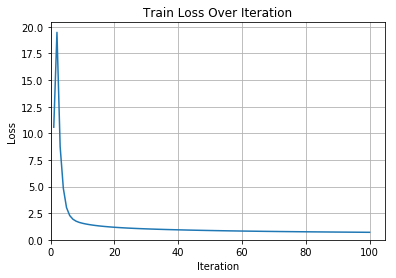

In [48]:
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history)
plt.grid()
plt.title("Train Loss Over Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xlim(0, None)
plt.ylim(0, None);

In [49]:
len(train_loss_history)

100

### Looks good!
## Let's see the examples that it performs well and those that it does poorly

In [50]:
loss_sorted = binary_class_cross_entropy_loss(feedforward(X_train, weights, biases), Y_train, per_example=True).sort(dim=0)
top5_highloss = (loss_sorted[0][-5:], loss_sorted[1][-5:])
top5_lowloss = (loss_sorted[0][:5], loss_sorted[1][:5])

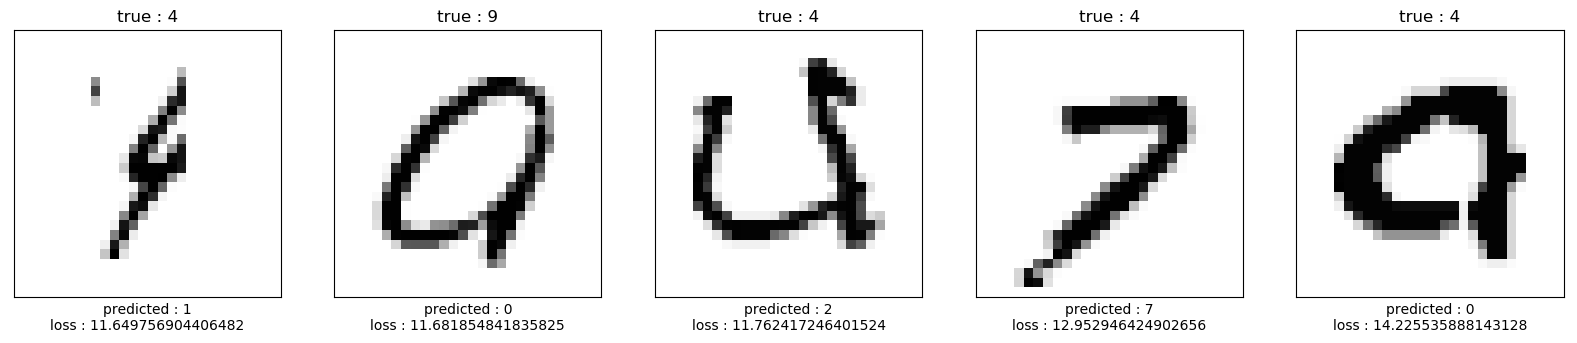

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_highloss[1]), figsize=(20, 20), dpi=100)
for loss, idx, ax in zip(top5_highloss[0], top5_highloss[1], axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"true : {Y_train[idx].argmax()}")
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[idx].unsqueeze(0), weights, biases)).item()}\n"
                  f"loss : {loss}")
    ax.imshow(X_train[idx].reshape(28, 28), cmap="Greys")

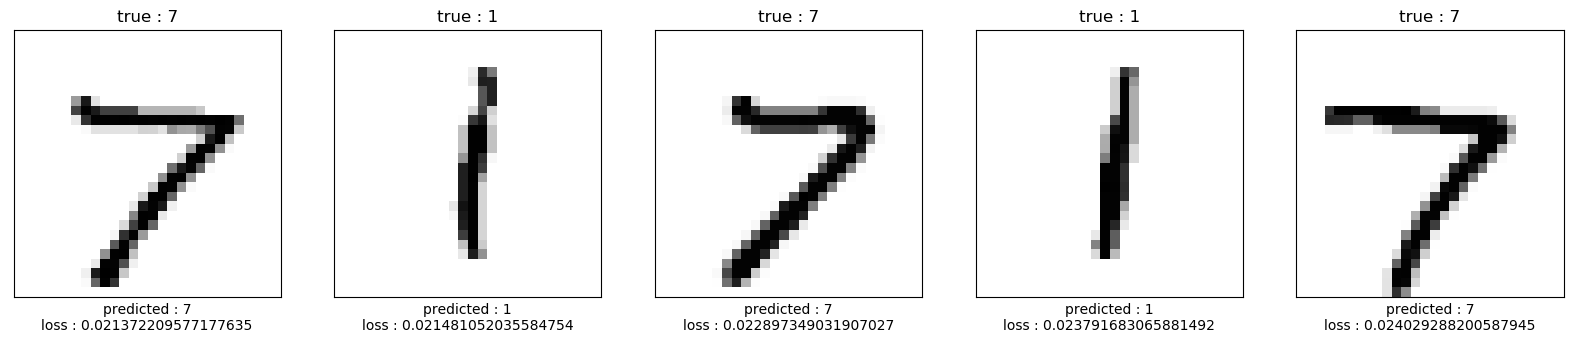

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_lowloss[1]), figsize=(20, 20), dpi=100)
for loss, idx, ax in zip(top5_lowloss[0], top5_lowloss[1], axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"true : {Y_train[idx].argmax()}")
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[idx].unsqueeze(0), weights, biases)).item()}\n"
                  f"loss : {loss}")
    ax.imshow(X_train[idx].reshape(28, 28), cmap="Greys")

### Interestingly, it got really good at classifying few specific digits!

---
## Making the training process into a function so that it can be used in different contexts
* (WIP)!

In [ ]:
def train(X_train, Y_train, weight_matrices, bias_matrices=None, X_val=None, Y_val=None, X_test=None, Y_test=None,
          epoch=100, learning_rate=1.0, reg_coef=0,
          report_interval=10, reset_progress=False,
          tol_loss=1e-3, tol_step = 1e-8,
          logs=[[],[],[],[]], backups=[], n_backups=0):

    assert bias_matrices is None or len(weight_matrices) == len(bias_matrices), "The number of weights and biases must match"
    assert isinstance(report_interval, int), "The reporting interval must be an integer value, but {type(report_interval)} received"
    assert isinstance(n_backups, int), f"The number of backups must be an integer value, but {type(n_backups)} received"
    
    train_loss_history = logs[0]
    train_acc_history = logs[1]
    val_loss_history = logs[2]
    val_acc_history = logs[3]
    
    params = weight_matrices + bias_matrices if bias_matrices is not None else weight_matrices
    
    if reset_progress is True:
        reset(weight_matrices)
        if bias_matrices is not None:
            reset(bias_matrices)
        train_loss_history.clear()
        train_acc_history.clear()
        val_loss_history.clear()
        val_acc_history.clear()

    exit_reason = ""
    
    if report_interval <= 0:
        report_interval = epoch + 1

    backup_during_training = True if n_backups > 0 else False
    if backup_during_training:
        backup_interval = epoch // n_backups # backup the parameters, iteration number(starting from 1), and train loss for 'n_backups' times during a full set of iterations
        backups.append({'weights':[weight.data.clone() for weight in weight_matrices],
                        'biases':[bias.data.clone() for bias in (bias_matrices if bias_matrices is not None else [])],
                        'index':len(train_loss_history),
                        'train_loss':999 if train_loss_history == [] else train_loss_history[-1]})
        
    for iteration in range(epoch):
        output = feedforward(X_train, weight_matrices, bias_matrices)
        loss = loss_function(output, Y_train, weight_matrices, reg_coef, len(X_train))

        loss.backward()

        for param in ():
            param.data -= learning_rate * param.grad.data
            param.grad.data.zero_()

        train_pred = predict(output, one_hot=True)

        train_loss_history.append(loss.item())
        train_acc_history.append(accuracy_score(train_pred, Y_train))

        if X_val is not None and Y_val is not None:
            val_prob = feedforward(X_val, weights, biases)
            val_pred = predict(val_prob, one_hot=True)

            val_loss_history.append(binary_class_cross_entropy_loss(val_prob, Y_val).item())
            val_acc_history.append(accuracy_score(val_pred, Y_val))

        if (iteration + 1) % report_interval == 0:
            print(f"\nIteration {iteration + 1}")
            print(f"[Training Loss = {train_loss_history[-1]:.6f}\t"
                  f"Training Accuracy = {train_acc_history[-1]:.6f}]")
                if X_val is not None and Y_val is not None:
                    print(f"[Validation Loss = {val_loss_history[-1]:.6f}\t\t"
                          f"Validation Accuracy = {val_acc_history[-1]:.6f}]")

        if backup_during_training is True and iteration % checkpoint_interval == 0:
            backups.append({'parameters':[param.clone() for param in (weights + biases)],
                            'index':len(train_loss_history),
                            'train_loss':train_loss_history[-1]})


        if train_loss_history[-1] < tol_loss:
            exit_reason = "Loss value less than tol_loss value"
            break

        elif len(train_loss_history) > 1 and abs(train_loss_history[-1] - train_loss_history[-2]) < tol_step:
            exit_reason = "Loss value change less than tol_step value"
            break

        elif iteration == (epoch - 1):
            exit_reason = "Iteration finished"

    print(f"\n{exit_reason}")
    print(f"Training finished in {iteration + 1} iterations")
    print(f"\nFinal training loss = {train_loss_history[-1]}")
    print(f"Final training accuracy = {train_acc_history[-1]}")
    if X_val is not None and Y_val is not None:
        print(f"\nFinal validation loss = {val_loss_history[-1]}")
        print(f"Final validation accuracy = {val_loss_history[-1]}")
    if X_test is not None and Y_test is not None:
        test_accuracy = accuracy_score(feedforward(X_test, weight_matrices, bias_matrices), Y_test)
        print(f"\nTest accuracy = {test_accuracy}")